In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
# from keras import layers


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("Not enough GPU hardware devices available")
else:
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-06-11 12:11:23.410668: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-11 12:11:23.433738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-11 12:11:23.434027: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.23GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2023-06-11 12:11:23.434204: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-11 12:11:23.435476: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-11 12:11:23.436642: I tensorflow/st

In [3]:
# tf.debugging.set_log_device_placement(True)       # Will print the log information of every execution of tensorflow, mainly about 

In [4]:
#Size of our input images
# SIZE = 128        # It was this value at the beginning, but the image display was poor. 
SIZE = 160
# SIZE = 228          # It was 224, but in order for the current autoencoder model configuration work adequately, we changed it 228

# Setting the training and testing datasets 

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [5]:
def my_crop(img, start_y, start_x, desired_height, desired_width):
  if K.image_data_format() == 'channels_last':
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy = desired_height #input desired output size
    dx = desired_width #input desired output size
    # start_y = (height-dy)//2
    # start_x = (width-dx)//2
    return img[start_y:start_y+dy, start_x:(dx+start_x), :]
  else:
      assert img.shape[0] == 3
      height, width = img.shape[1], img.shape[2]
      dy = desired_height #input desired output size
      dx = desired_width #input desired output size
      # start_y = (height-dy)//2
      # start_x = (width-dx)//2
      return img[:,start_y:start_y + dy, start_x:(dx + start_x)]

def crop_generator(batches, start_y, start_x, crop_height, crop_width, flag=0):
    '''
    Take as input a Keras ImageGen (Iterator) and generate
    crops from the image batches generated by the original iterator
    '''
    # print("I'm in the crop_generataor function")
    while True:
      batch_x, batch_y = next(batches)  # In batch_x there are the images, in batch_y there are the labels
    #   print("hello")
    #   print('the shape of tensor batch_x is:', batch_x.shape)
    #   print('batch_y is:', batch_y)
      if flag==0:
        if K.image_data_format() == 'channels_last':
          batch_crops = np.zeros((batch_x.shape[0], crop_height, crop_width, 3))
          batch_crops_y = np.zeros((batch_y.shape[0], crop_height, crop_width, 3))
        else:
          batch_crops = np.zeros((batch_x.shape[0], 3, crop_height, crop_width))
          batch_crops_y = np.zeros((batch_y.shape[0], 3, crop_height, crop_width))
        for i in range(batch_x.shape[0]):
          #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
            batch_crops[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)
            batch_crops_y[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)
        yield (batch_crops, batch_crops_y)
      else: 
        if K.image_data_format() == 'channels_last':
          batch_crops = np.zeros((batch_x.shape[0], crop_height, crop_width, 3))
        else:
          batch_crops = np.zeros((batch_x.shape[0], 3, crop_height, crop_width))
        for i in range(batch_x.shape[0]):
          #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
            batch_crops[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)

        yield (batch_crops, batch_y)

In [6]:
(50-25)//2

12

In [7]:
# batch_size = 64
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "../../Images/june5Night/Positive/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Positive/",          # For work laptop
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'          # Class used for working with Autoencoders
    
    )

Found 295 images belonging to 1 classes.


In [8]:
train_crops = crop_generator(train_generator, 65, 69, 160,128)      # top, left, height, width

# Showing one sample of the training set images

Grabbing only one image of one batch of the training set.

In [9]:
images_in_batch = next(train_crops)


In [10]:
print(type(images_in_batch))
print(len(images_in_batch))

<class 'tuple'>
2


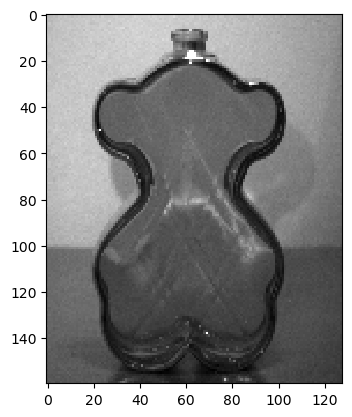

In [11]:
single_img = images_in_batch[0][0]
plt.imshow(single_img)

In [12]:
single_data= images_in_batch[1]
print(single_data)

[[[[0.74117649 0.74117649 0.74117649]
   [0.71372551 0.71372551 0.71372551]
   [0.73725492 0.73725492 0.73725492]
   ...
   [0.54509807 0.54509807 0.54509807]
   [0.54901963 0.54901963 0.54901963]
   [0.54509807 0.54509807 0.54509807]]

  [[0.74117649 0.74117649 0.74117649]
   [0.72549021 0.72549021 0.72549021]
   [0.72941178 0.72941178 0.72941178]
   ...
   [0.57254905 0.57254905 0.57254905]
   [0.5529412  0.5529412  0.5529412 ]
   [0.55686277 0.55686277 0.55686277]]

  [[0.74509805 0.74509805 0.74509805]
   [0.73333335 0.73333335 0.73333335]
   [0.74901962 0.74901962 0.74901962]
   ...
   [0.57647061 0.57647061 0.57647061]
   [0.54509807 0.54509807 0.54509807]
   [0.54509807 0.54509807 0.54509807]]

  ...

  [[0.34117648 0.34117648 0.34117648]
   [0.32941177 0.32941177 0.32941177]
   [0.33333334 0.33333334 0.33333334]
   ...
   [0.227451   0.227451   0.227451  ]
   [0.22352943 0.22352943 0.22352943]
   [0.22352943 0.22352943 0.22352943]]

  [[0.32549021 0.32549021 0.32549021]
   [0.3

In [13]:
print(images_in_batch[0].shape)

(32, 160, 128, 3)


In [14]:
print(single_img.shape)

(160, 128, 3)


In [15]:
print(single_img)

[[[0.74117649 0.74117649 0.74117649]
  [0.71372551 0.71372551 0.71372551]
  [0.73725492 0.73725492 0.73725492]
  ...
  [0.54509807 0.54509807 0.54509807]
  [0.54901963 0.54901963 0.54901963]
  [0.54509807 0.54509807 0.54509807]]

 [[0.74117649 0.74117649 0.74117649]
  [0.72549021 0.72549021 0.72549021]
  [0.72941178 0.72941178 0.72941178]
  ...
  [0.57254905 0.57254905 0.57254905]
  [0.5529412  0.5529412  0.5529412 ]
  [0.55686277 0.55686277 0.55686277]]

 [[0.74509805 0.74509805 0.74509805]
  [0.73333335 0.73333335 0.73333335]
  [0.74901962 0.74901962 0.74901962]
  ...
  [0.57647061 0.57647061 0.57647061]
  [0.54509807 0.54509807 0.54509807]
  [0.54509807 0.54509807 0.54509807]]

 ...

 [[0.34117648 0.34117648 0.34117648]
  [0.32941177 0.32941177 0.32941177]
  [0.33333334 0.33333334 0.33333334]
  ...
  [0.227451   0.227451   0.227451  ]
  [0.22352943 0.22352943 0.22352943]
  [0.22352943 0.22352943 0.22352943]]

 [[0.32549021 0.32549021 0.32549021]
  [0.34901962 0.34901962 0.34901962]
